In [292]:
import numpy as np
import pandas as pd

import statistics
import scipy

import scipy.stats as stats
from scipy.stats import chi2

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import mean_absolute_percentage_error as mape

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [293]:
# dados = pd.read_csv("./ibov.csv")
dados = pd.read_csv("./ibov_tf30MIN.csv")
dados.head(5)

,time,open,high,low,close,tick_volume,spread,real_volume,mma_20
0,2021-06-10 10:00:00,129903.0,130473.0,129903.0,130124.0,329486,0,174561900,NaN
1,2021-06-10 10:30:00,130129.0,130478.0,129862.0,130037.0,452718,0,242678400,NaN
2,2021-06-10 11:00:00,129982.0,130338.0,129833.0,130194.0,446193,0,226562700,NaN
3,2021-06-10 11:30:00,130172.0,130209.0,129543.0,129687.0,331824,0,154322700,NaN
4,2021-06-10 12:00:00,129718.0,129819.0,129596.0,129709.0,318381,0,184436100,NaN


Tamanho da série: 1106


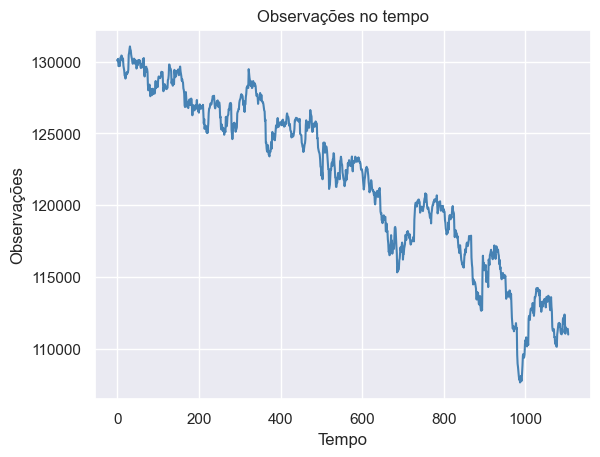

In [294]:
print("Tamanho da série: " + str(len(dados)))

plt.title("Observações no tempo")  
plt.xlabel("Tempo")  
plt.ylabel("Observações")  
plt.plot(dados.index, dados.close, color ="steelblue")  
plt.show()

In [295]:
import pymannkendall as mk

ibov_close = np.array(dados.close.astype(int))

result = mk.original_test(ibov_close)
# result = mk.original_test(ibov_close[400:800]) trecho estacionário
print(result)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-41.6335157133379, Tau=-0.835914346264309, s=-510798.0, var_s=150525647.33333334, slope=-17.253658536585366, intercept=132263.1463414634)


In [296]:
# Trending test - Cox-Stuart method
#trend_type = "l" --> "decreasing trend"
#trend_type = "r" --> "increasing trend"

def simpleCS (x, trend_type = "l"):
    n0 = len(x)%2
    if n0 == 1:
        remover = int((len(x))/2)
        x = np.delete(x, int((len(x))/2))
        
    half = len(x)/2
    
    x1 = x[np.arange(0, half, dtype=int)]
    x2 = x[np.arange(half, len(x), dtype=int)]
    
    n = np.sum((x2 - x1) != 0)
    t = np.sum(x1 < x2)
    
    if trend_type == "l":
        pvalue = stats.binom.cdf(t, n, 0.5)
    else:
        pvalue = 1 - stats.binom.cdf(t - 1, n, 0.5)
    
    return pvalue

In [297]:
simpleCS(ibov_close, trend_type="l")
#trend_type = "l" --> "decreasing trend"

3.391660689521908e-167

In [298]:
simpleCS(ibov_close, trend_type="r")
#trend_type = "r" --> "increasing trend"

1.0

In [299]:
def simpleKW (y, freq = 12):    
    Rank = np.array(pd.Series(y).rank(method='average', na_option='keep'))
    extra = freq - len(Rank)%freq
    dat = np.concatenate((np.repeat(np.nan, extra), Rank))
    yMAT = dat.reshape((int(len(dat)/freq), freq))
    Nobs = np.apply_along_axis(lambda x: np.count_nonzero(~np.isnan(x)), 0, yMAT)
    R2n = np.power(np.apply_along_axis(np.nansum, 0, yMAT), 2)/Nobs
    H = freq/(sum(Nobs) * (sum(Nobs) + 1)) * sum(R2n) - 3 * (sum(Nobs) + 1)

    if sum(np.unique(Rank, return_counts=True)[1]>1) > 0:
        valor = np.unique(Rank, return_counts=True)[1]
        valor = valor[valor > 1]
        sumT = sum(np.power(valor, 3) - valor)
        Correction = 1 - sumT/(np.power(len(y),3) - len(y))
        H = H/Correction

    return 1 - chi2.cdf(H, freq-1)

In [300]:
simpleKW(ibov_close, 40)

0.0

Tamanho da série: 1106


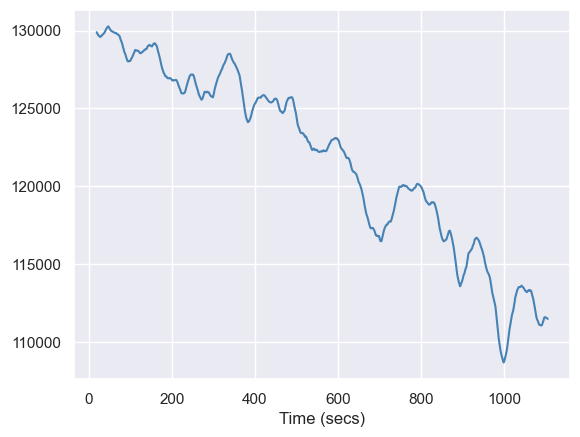

In [301]:
smoothed_xt = pd.DataFrame(ibov_close).rolling(window=20).mean()

print("Tamanho da série: " + str(len(smoothed_xt)))

plt.plot(np.arange(len(smoothed_xt)),smoothed_xt, color ="steelblue")
plt.xlabel('Time (secs)')
plt.grid(True)
plt.show()

Tamanho da série: 1106


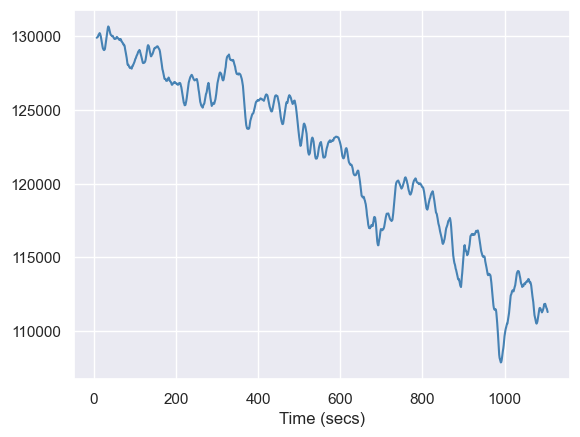

In [302]:
smoothed_xt = pd.DataFrame(ibov_close).rolling(window=8).mean()

print("Tamanho da série: " + str(len(smoothed_xt)))

plt.plot(np.arange(len(smoothed_xt)),smoothed_xt, color ="steelblue")
plt.xlabel('Time (secs)')
plt.grid(True)
plt.show()

Tamanho da série: 1105


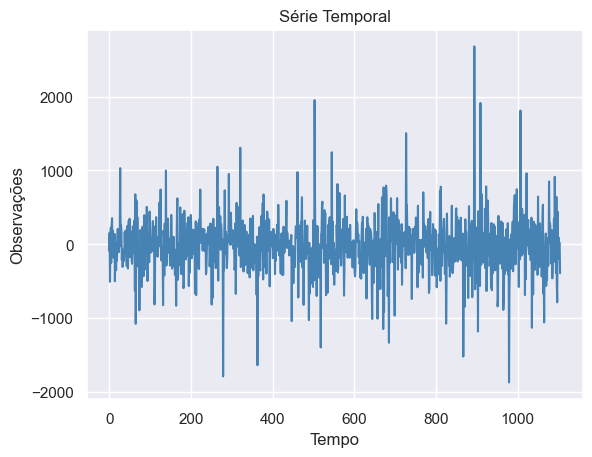

In [303]:

xt_detrend = np.diff(ibov_close)
print("Tamanho da série: " + str(len(xt_detrend)))

plt.title("Série Temporal")  
plt.xlabel("Tempo")  
plt.ylabel("Observações")  
plt.plot(xt_detrend, color ="steelblue")  
plt.show()

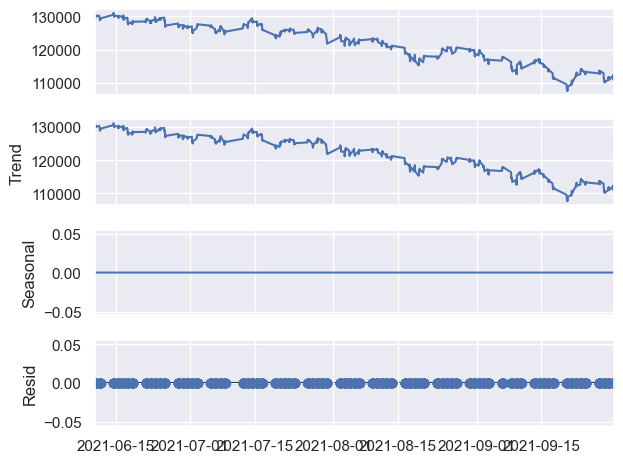

In [304]:
xt = pd.DataFrame({"Date": dados.time, "obs": dados.close})
xt.set_index('Date',inplace=True)
xt.index=pd.to_datetime(xt.index)
decompose_result_mult = seasonal_decompose(xt, model="additive", period=1)
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

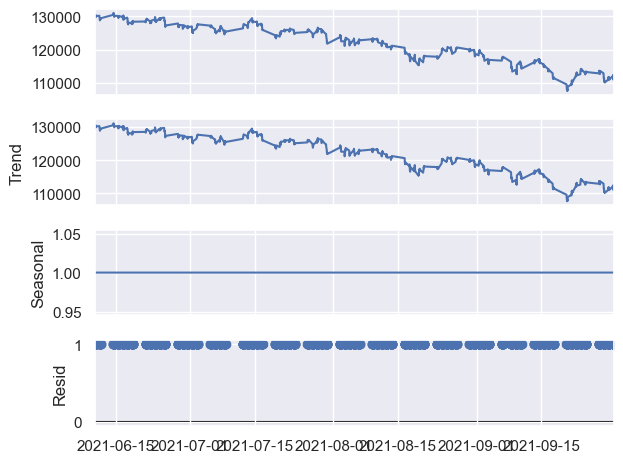

In [333]:
xt = pd.DataFrame({"Date": dados.time, "obs": dados.close})
xt.set_index('Date',inplace=True)
xt.index=pd.to_datetime(xt.index)
decompose_result_mult = seasonal_decompose(xt, model="mul", period=1)
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

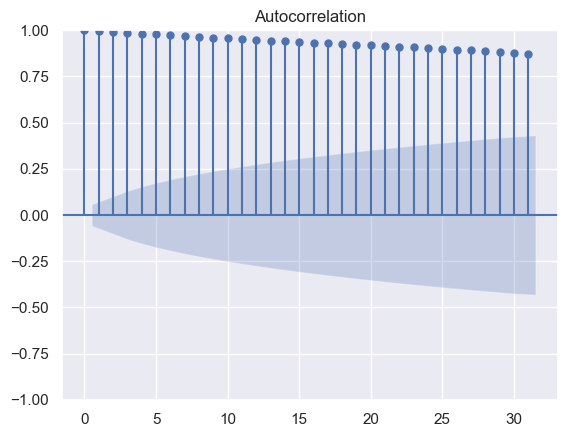

In [305]:
plot_acf(ibov_close)
plt.show()

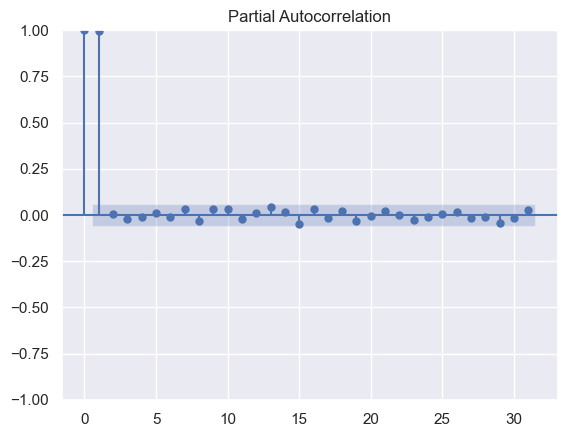

In [306]:
plot_pacf(ibov_close)
plt.show()

(840, 1) (266, 1)


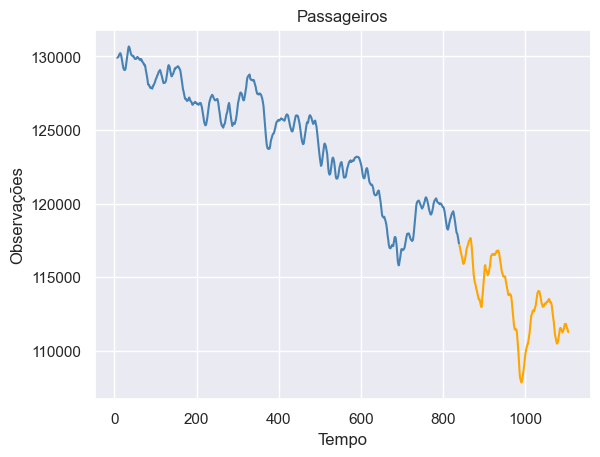

In [307]:
X = smoothed_xt
X.index.freq = "MS"
# Split into train and test set
X_train = X[:840]
X_test = X[840:]
print(X_train.shape,X_test.shape)
plt.title("Passageiros")  
plt.xlabel("Tempo")  
plt.ylabel("Observações")  
plt.plot(X_train, color ="steelblue")
plt.plot(X_test, color ="orange")  
plt.show()

In [308]:
X = pd.read_csv("./ibov_tf30MIN.csv", parse_dates=True)
X.index.freq = "MS"

# Split into train and test set
X_train = X[:840]
X_test = X[840:]

Validando o modelo:
MSE: 4115858.3573052953
RMSE: 2028.7578360428568
MAE: 1542.461677520506
MAPE: 0.013711088450869576


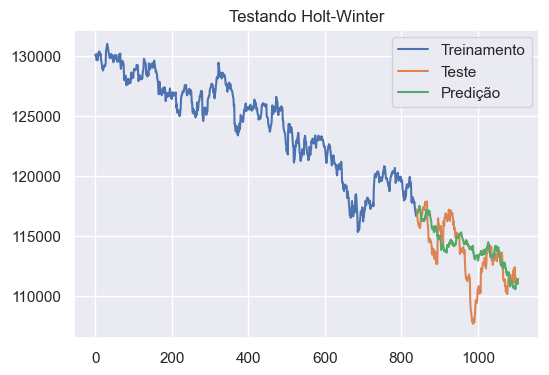

In [326]:
#treinar o modelo
model = ExponentialSmoothing(X_train["close"], 
                             trend="add", seasonal="add", 
                             seasonal_periods=180).fit()
#predizer observações
Y = model.forecast(266)
X_train["close"].plot(legend=True,label="Treinamento")
X_test["close"].plot(legend=True,label="Teste",figsize=(6,4))
Y.plot(legend=True,label="Predição")
plt.title("Testando Holt-Winter")
plt.plot()
print("Validando o modelo:")
print(f"MSE: {mse(X_test['close'], Y)}")
print(f"RMSE: {np.sqrt(mse(X_test['close'], Y))}")
print(f"MAE: {mae(X_test['close'], Y)}")
print(f"MAPE: {mape(X_test['close'], Y)}")

Validando o modelo:
MSE: 27457524.035994433
RMSE: 5239.992751521173
MAE: 4425.345202106389
MAPE: 0.03953508495723801


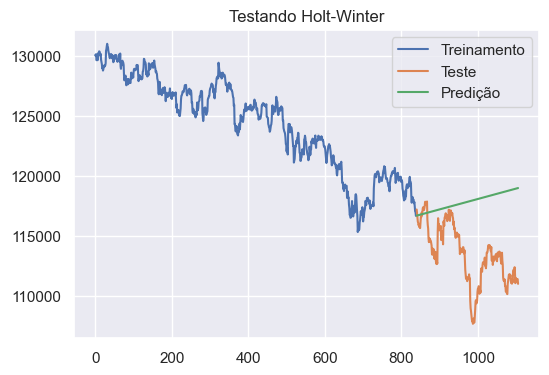

In [332]:
model = ExponentialSmoothing(X_train["close"], 
                             trend="add", 
                             seasonal_periods=180).fit()
#predizer observações
Y = model.forecast(266)
X_train["close"].plot(legend=True,label="Treinamento")
X_test["close"].plot(legend=True,label="Teste",figsize=(6,4))
Y.plot(legend=True,label="Predição")
plt.title("Testando Holt-Winter")
plt.plot()
print("Validando o modelo:")
print(f"MSE: {mse(X_test['close'], Y)}")
print(f"RMSE: {np.sqrt(mse(X_test['close'], Y))}")
print(f"MAE: {mae(X_test['close'], Y)}")
print(f"MAPE: {mape(X_test['close'], Y)}")

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [ ]:
stepwise_fit = auto_arima(X_train["close"],
                          start_p=0,
                          start_q=0,
                          max_p=6,
                          max_q=3,
                          information_criterion = 'aic',
                          seasonal=True,
                          trace=True,
                          m=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=12210.620, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12211.673, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12210.817, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12210.893, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12211.437, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=12208.885, Time=0.10 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=12210.751, Time=0.27 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=12208.815, Time=0.10 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=12210.711, Time=0.30 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=12212.686, Time=1.11 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12210.829, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=12212.680, Time=1.07 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=12208.561, Time=0.05 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=12210.524, Time=0.16 sec
 ARIM

In [ ]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  840
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6104.718
Date:                Thu, 29 Feb 2024   AIC                          12211.437
Time:                        14:03:50   BIC                          12216.169
Sample:                             0   HQIC                         12213.251
                                - 840                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.222e+05   3530.837     34.605      0.000    1.15e+05    1.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               477.86
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.12
Prob(H) (two-sided):                  0.17   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC: 12642.986408957859 | BIC: 12657.136193278422
Validando o modelo:
MSE: 17695662.589110963
RMSE: 4206.621279496285
MAE: 3504.040572922548
MAPE: 0.03132619228543296


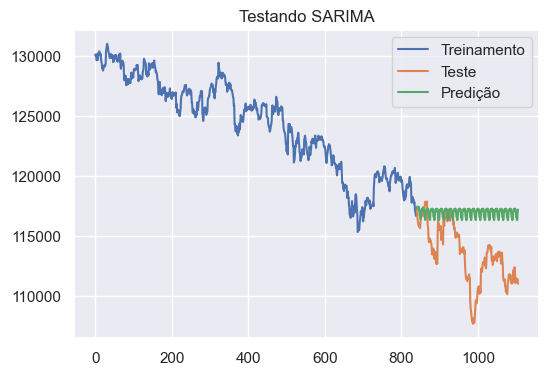

In [ ]:
mod = sm.tsa.statespace.SARIMAX(X_train.close,
                                order=(2,0,0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit(disp=0)
print(f'AIC: {results.aic} | BIC: {results.bic}')
Y = results.predict(start=len(X_train),end=len(X_train)+len(X_test)-1).rename('Forecast')
X_train["close"].plot(legend=True,label="Treinamento")
X_test["close"].plot(legend=True,label="Teste",figsize=(6,4))
Y.plot(legend=True,label="Predição")
plt.title("Testando SARIMA")
print("Validando o modelo:")
print(f"MSE: {mse(X_test['close'], Y)}")
print(f"RMSE: {np.sqrt(mse(X_test['close'], Y))}")
print(f"MAE: {mae(X_test['close'], Y)}")
print(f"MAPE: {mape(X_test['close'], Y)}")

AIC: 12312.326370842162 | BIC: 12331.099665515241
Validando o modelo:
MSE: 8408778.57133943
RMSE: 2899.789401204755
MAE: 2227.6864969741237
MAPE: 0.019905059126046464


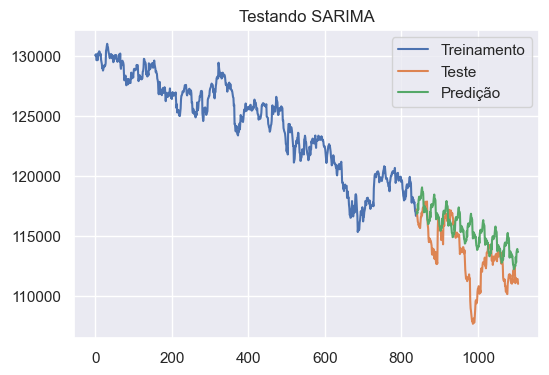

In [ ]:
mod = sm.tsa.statespace.SARIMAX(X_train.close,
                                order=(1,0,0),
                                trend='ct',
                                seasonal_order=(0, 1, 0, 32),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit(disp=0)
print(f'AIC: {results.aic} | BIC: {results.bic}')
Y = results.predict(start=len(X_train),end=len(X_train)+len(X_test)-1).rename('Forecast')
X_train["close"].plot(legend=True,label="Treinamento")
X_test["close"].plot(legend=True,label="Teste",figsize=(6,4))
Y.plot(legend=True,label="Predição")
plt.title("Testando SARIMA")
print("Validando o modelo:")
print(f"MSE: {mse(X_test['close'], Y)}")
print(f"RMSE: {np.sqrt(mse(X_test['close'], Y))}")
print(f"MAE: {mae(X_test['close'], Y)}")
print(f"MAPE: {mape(X_test['close'], Y)}")

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AICC=12210.668, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AICC=12211.687, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AICC=12210.865, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AICC=12210.941, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AICC=12211.442, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AICC=12208.914, Time=0.08 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AICC=12210.799, Time=0.26 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AICC=12208.844, Time=0.09 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AICC=12210.759, Time=0.29 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AICC=12212.758, Time=1.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AICC=12210.877, Time=0.25 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AICC=12212.752, Time=0.93 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AICC=12208.575, Time=0.05 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AICC=12210.552, Time

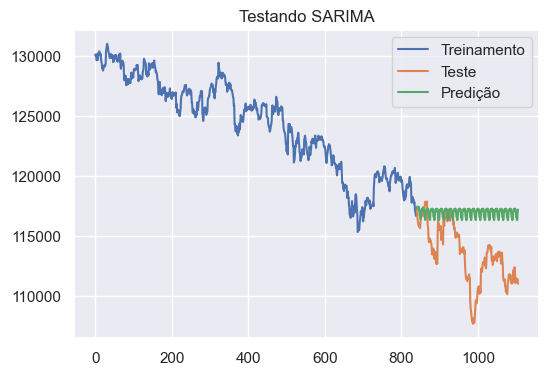

In [337]:
stepwise_fit = auto_arima(X_train["close"],
                          start_p=0,
                          start_q=0,
                          max_p=6,
                          max_q=3,
                          information_criterion = 'aicc',
                          seasonal=True,
                          trace=True,
                          m=12)

mod = sm.tsa.statespace.SARIMAX(X_train.close,
                                order=(2,0,0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit(disp=0)
print(f'AIC: {results.aic} | BIC: {results.bic}')
Y = results.predict(start=len(X_train),end=len(X_train)+len(X_test)-1).rename('Forecast')
X_train["close"].plot(legend=True,label="Treinamento")
X_test["close"].plot(legend=True,label="Teste",figsize=(6,4))
Y.plot(legend=True,label="Predição")
plt.title("Testando SARIMA")
print("Validando o modelo:")
print(f"MSE: {mse(X_test['close'], Y)}")
print(f"RMSE: {np.sqrt(mse(X_test['close'], Y))}")
print(f"MAE: {mae(X_test['close'], Y)}")
print(f"MAPE: {mape(X_test['close'], Y)}")